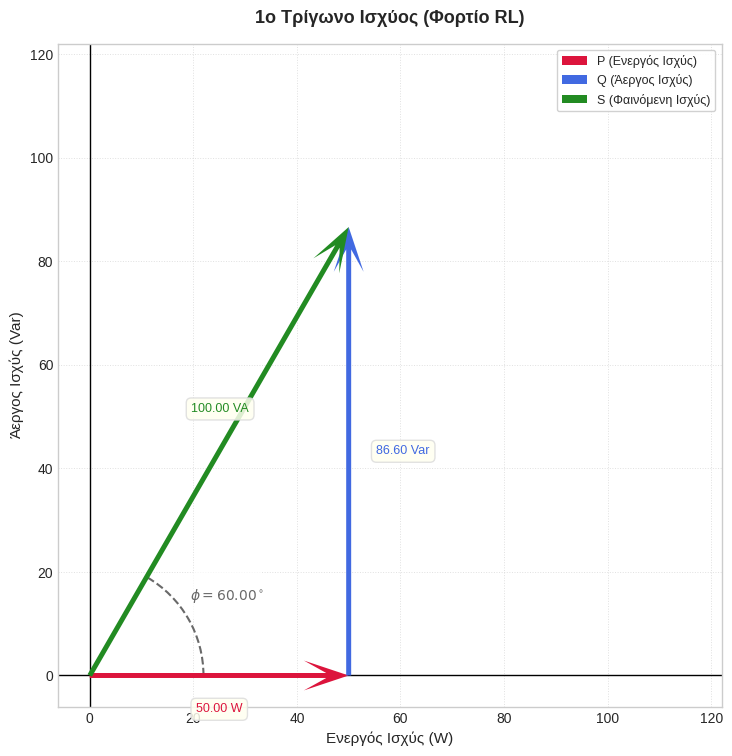

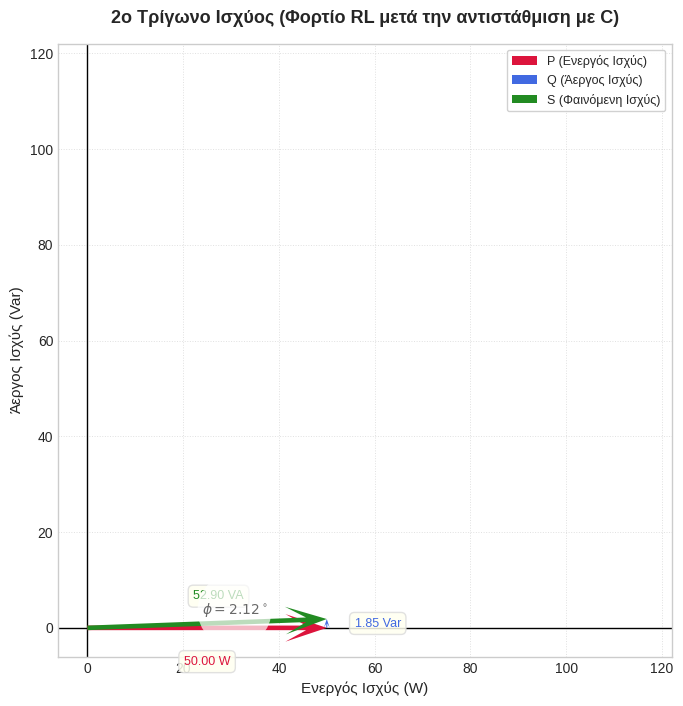

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

# --- Define plot style ---
# Using a seaborn style for a more modern look.
# Other options: 'ggplot', 'seaborn-v0_8-darkgrid', 'bmh', 'Solarize_Light2'
plt.style.use('seaborn-v0_8-whitegrid')

# --- Define a common bounding box style for annotations ---
# Softer colors like ivory or lightyellow for the background, with a subtle border.
bbox_props = dict(boxstyle="round,pad=0.4", fc="ivory", ec="gainsboro", alpha=0.85)

def plot_power_triangle(ax, P, Q, S_val_label, title, common_max_lim):
    """
    Plots a power triangle on the given axes.

    Args:
        ax: Matplotlib axes object to plot on.
        P: Active power (W).
        Q: Reactive power (Var).
        S_val_label: Apparent power value to display in the label (VA).
                     The S arrow length is determined by P and Q.
        title: Title of the plot.
        common_max_lim: The maximum limit for x and y axes for consistent scaling.
    """
    # Calculate angle phi using arctan2 for robustness (handles P=0 correctly)
    phi_rad = np.arctan2(Q, P)
    phi_deg = np.degrees(phi_rad)

    # Arrow properties for a clearer and more aesthetic look
    arrow_head_width = 6    # Head width in points
    arrow_head_length = 9   # Head length in points
    arrow_line_width = 1.8  # Linewidth of the arrow shaft and head outline

    # Colors (can be customized further)
    color_P = 'crimson'        # A strong red for Active Power
    color_Q = 'royalblue'      # A nice blue for Reactive Power
    color_S = 'forestgreen'    # A clear green for Apparent Power
    color_phi = 'dimgray'      # Color for angle arc and text

    # Plot P (Active Power) from origin along x-axis
    # zorder ensures arrows are drawn on top of grid/arc
    ax.quiver(0, 0, P, 0, angles='xy', scale_units='xy', scale=1, color=color_P,
              label='P (Ενεργός Ισχύς)', headwidth=arrow_head_width,
              headlength=arrow_head_length, linewidth=arrow_line_width, zorder=3)

    # Plot Q (Reactive Power) starting from the end of P, vertically
    ax.quiver(P, 0, 0, Q, angles='xy', scale_units='xy', scale=1, color=color_Q,
              label='Q (Άεργος Ισχύς)', headwidth=arrow_head_width,
              headlength=arrow_head_length, linewidth=arrow_line_width, zorder=3)

    # Plot S (Apparent Power) as the hypotenuse from origin to (P,Q)
    # The length of this arrow will be sqrt(P^2 + Q^2)
    ax.quiver(0, 0, P, Q, angles='xy', scale_units='xy', scale=1, color=color_S,
              label='S (Φαινόμενη Ισχύς)', headwidth=arrow_head_width,
              headlength=arrow_head_length, linewidth=arrow_line_width, zorder=3)

    # --- Annotations for P, Q, S values ---
    # Using textcoords="offset points" for consistent spacing from the anchor point.
    # Fontsize and offsets adjusted for better readability.

    # P annotation (below the P arrow)
    ax.annotate(f'{P:.2f} W', xy=(P / 2, 0), textcoords="offset points", xytext=(0, -20),
                ha='center', va='top', color=color_P, bbox=bbox_props, fontsize=9)

    # Q annotation (to the right of the Q arrow)
    ax.annotate(f'{Q:.2f} Var', xy=(P, Q / 2), textcoords="offset points", xytext=(20, 0),
                ha='left', va='center', color=color_Q, bbox=bbox_props, fontsize=9)

    # S annotation (near the S arrow)
    # Positioned carefully to avoid too much overlap.
    # For S, using an offset relative to the midpoint of S.
    # A small rotation matching the S arrow angle could also be an option for S text.
    s_annot_x = P * 0.55
    s_annot_y = Q * 0.55
    s_offset_x = 10 * np.cos(phi_rad + np.pi/2) # Offset perpendicular to S
    s_offset_y = 10 * np.sin(phi_rad + np.pi/2)
    ax.annotate(f'{S_val_label:.2f} VA', xy=(s_annot_x, s_annot_y),
                textcoords="offset points", xytext=(s_offset_x, s_offset_y + (5 if Q>0 else -5)), # Adjust y offset based on Q direction
                ha='center', va='bottom' if Q >=0 else 'top', color=color_S, bbox=bbox_props, fontsize=9)


    # --- Angle phi visualization ---
    # Draw an arc for phi if P or Q is non-zero (i.e., S is not zero)
    if P**2 + Q**2 > 1e-6: # Check if S is effectively non-zero
        # Determine arc radius based on a fraction of the axis limit for consistency
        arc_display_radius = common_max_lim * 0.18

        phi_arc = Arc((0,0), width=arc_display_radius*2, height=arc_display_radius*2, angle=0,
                      theta1=0, theta2=phi_deg, color=color_phi, linestyle='--', linewidth=1.5, zorder=2, label='_nolegend_')
        ax.add_patch(phi_arc)

        # Position phi label slightly outside the arc, along its bisector.
        # Adjustments to prevent label from sitting directly on axes for 0/90 deg.
        label_angle_rad = phi_rad / 2
        label_r_factor = 1.4 # Multiplier for arc radius to position text

        phi_label_x = arc_display_radius * label_r_factor * np.cos(label_angle_rad)
        phi_label_y = arc_display_radius * label_r_factor * np.sin(label_angle_rad)

        ha_phi, va_phi = 'center', 'center'

        # Fine-tune alignment for edge cases (angles near axes)
        if abs(phi_rad) < np.deg2rad(10): # Near horizontal axis
            va_phi = 'bottom' if phi_rad >= 0 else 'top'
            phi_label_y += np.sign(phi_rad if phi_rad!=0 else 1) * common_max_lim * 0.01 # Small vertical shift
        elif abs(abs(phi_rad) - np.pi/2) < np.deg2rad(10): # Near vertical axis
            ha_phi = 'left' if phi_rad > 0 else 'right' # Shift away from y-axis
            phi_label_x += np.sign(np.cos(label_angle_rad) if np.cos(label_angle_rad)!=0 else 1) * common_max_lim * 0.01


        ax.text(phi_label_x, phi_label_y, f'$\phi = {phi_deg:.2f}^\circ$',
                ha=ha_phi, va=va_phi, color=color_phi, fontsize=10,
                bbox=dict(boxstyle="circle,pad=0.3", fc="white", alpha=0.7, ec="none"))

    # --- Plot settings ---
    ax.set_xlim(-common_max_lim * 0.05, common_max_lim) # Start slightly left of 0 to show y-axis line
    ax.set_ylim(-common_max_lim * 0.05, common_max_lim) # Start slightly below 0 to show x-axis line
    ax.set_xlabel('Ενεργός Ισχύς (W)', fontsize=11)
    ax.set_ylabel('Άεργος Ισχύς (Var)', fontsize=11)
    ax.set_title(title, fontsize=13, weight='bold', pad=15) # Add padding to title

    # Add legend, placed in a suitable location
    ax.legend(loc='upper right', fontsize=9, frameon=True, framealpha=0.9, fancybox=True)

    # Grid settings - make it less obtrusive
    ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.6)

    # Axis lines (origin lines) - ensure they are visible
    ax.axhline(0, color='black', linewidth=1.0, zorder=1)
    ax.axvline(0, color='black', linewidth=1.0, zorder=1)

    # Set aspect ratio to 'equal' so that the triangle is visually correct
    # (i.e., a 45-degree angle looks like 45 degrees).
    ax.set_aspect('equal', adjustable='box')

# --- Δεδομένα για το 1ο Τρίγωνο Ισχύος (RL φορτίο) ---
P1 = 50  # Ενεργός Ισχύς (W)
Q1 = 86.6 # Άεργος Ισχύς (Var) - Επαγωγική
S1_label = 100 # Φαινόμενη Ισχύς (VA) - Label for S, as provided in original data

# --- Δεδομένα για το 2ο Τρίγωνο Ισχύος (RLC φορτίο μετά την αντιστάθμιση) ---
P2 = 50  # Ενεργός Ισχύς (W)
Q2 = 1.85 # Άεργος Ισχύς (Var) - Επαγωγική (πολύ μικρή μετά την αντιστάθμιση)
S2_label = 52.9 # Φαινόμενη Ισχύς (VA) - Label for S, as provided

# --- Determine common axis limits for consistent comparison ---
# The original code used S1_label * 1.2. This value is used for both plots.
# S1_label = 100, so common_limit = 120.
common_plot_limit = S1_label * 1.22 # Slightly increased for more padding around elements

# --- Δημιουργία και Εμφάνιση του 1ου Τριγώνου Ισχύος ---
# Increase figure size for better clarity of details
fig1, ax1 = plt.subplots(figsize=(7.5, 7.5))
plot_power_triangle(ax1, P1, Q1, S1_label, '1ο Τρίγωνο Ισχύος (Φορτίο RL)', common_plot_limit)
plt.tight_layout(pad=0.5) # Adjust layout to prevent overlap
plt.show()

# --- Δημιουργία και Εμφάνιση του 2ου Τριγώνου Ισχύος ---
fig2, ax2 = plt.subplots(figsize=(7.5, 7))
plot_power_triangle(ax2, P2, Q2, S2_label, '2ο Τρίγωνο Ισχύος (Φορτίο RL μετά την αντιστάθμιση με C)', common_plot_limit)
plt.tight_layout(pad=0.5)
plt.show()

1ο Τρίγωνο - Έλεγχος: S = √(P² + Q²) = √(50.0² + 86.6²) = 100.0 VA
2ο Τρίγωνο - Έλεγχος: S = √(P² + Q²) = √(50.0² + 1.85²) = 50.0 VA


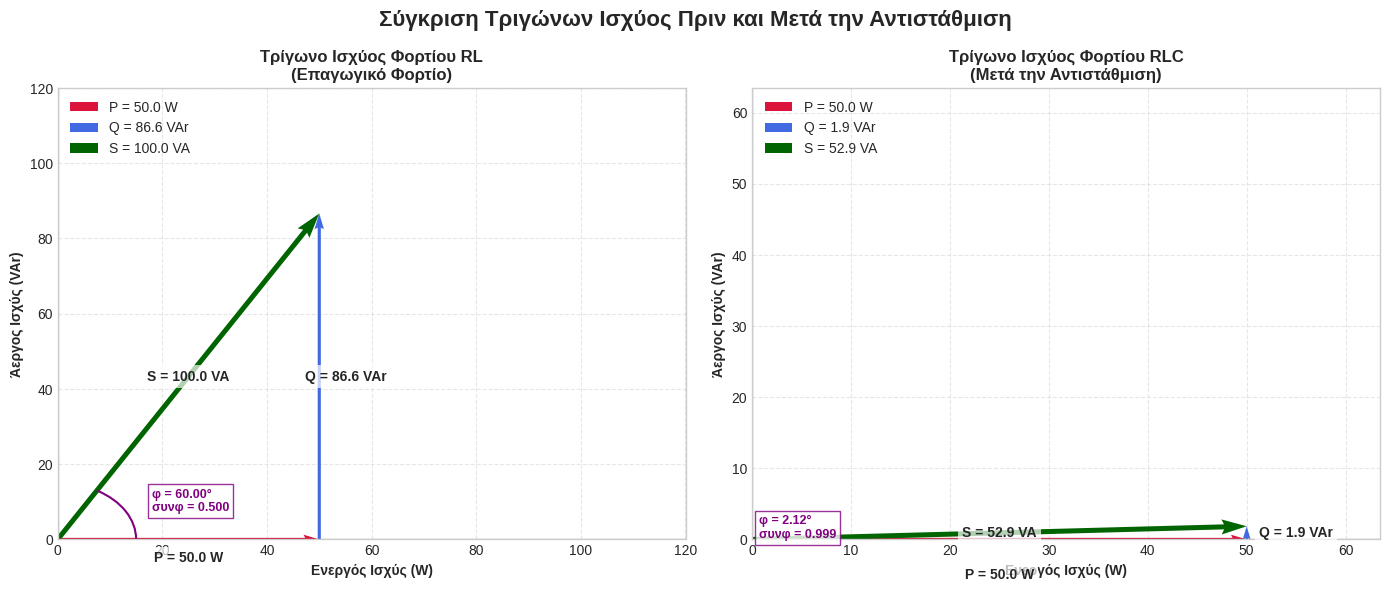

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

# Ορισμός συναρτήσεων βοηθητικών για την οπτικοποίηση
def draw_power_triangle(ax, P, Q, S, title, color_scheme=None):
    """
    Σχεδιάζει ένα τρίγωνο ισχύος με τις δοσμένες παραμέτρους

    Παράμετροι:
    - ax: Το αντικείμενο axes για το σχεδιασμό
    - P: Ενεργός ισχύς (W)
    - Q: Άεργος ισχύς (VAr)
    - S: Φαινόμενη ισχύς (VA)
    - title: Τίτλος του διαγράμματος
    - color_scheme: Προαιρετικό λεξικό με χρώματα για κάθε συνιστώσα
    """
    if color_scheme is None:
        color_scheme = {
            'P': 'crimson',       # Κόκκινο για την ενεργό ισχύ
            'Q': 'royalblue',     # Μπλε για την άεργο ισχύ
            'S': 'darkgreen',     # Πράσινο για τη φαινόμενη ισχύ
            'grid': '#DDDDDD',    # Ανοιχτό γκρι για το πλέγμα
            'angle': 'purple'     # Μωβ για τη γωνία φ
        }

    # Υπολογισμός της γωνίας φ (συντελεστής ισχύος)
    phi_rad = np.arctan2(Q, P)  # Χρήση arctan2 για σωστή διαχείριση τεταρτημορίων
    phi_deg = np.degrees(phi_rad)
    power_factor = np.cos(phi_rad)

    # Σχεδιασμός των διανυσμάτων ισχύος
    ax.quiver(0, 0, P, 0, angles='xy', scale_units='xy', scale=1,
              color=color_scheme['P'], width=0.005,
              label=f'P = {P:.1f} W')

    ax.quiver(P, 0, 0, Q, angles='xy', scale_units='xy', scale=1,
              color=color_scheme['Q'], width=0.005,
              label=f'Q = {Q:.1f} VAr')

    ax.quiver(0, 0, P, Q, angles='xy', scale_units='xy', scale=1,
              color=color_scheme['S'], width=0.008,
              label=f'S = {S:.1f} VA')

    # Σχεδιασμός του τόξου για τη γωνία φ
    r = min(P, Q) * 0.3  # Ακτίνα του τόξου
    arc = Arc((0, 0), 2*r, 2*r, theta1=0, theta2=phi_deg,
              color=color_scheme['angle'], lw=1.5, linestyle='-')
    ax.add_patch(arc)

    # Προσθήκη σημειώσεων
    mid_P = P / 2
    mid_Q = Q / 2

    # Στυλ κειμένου
    text_style = {'fontsize': 10, 'fontweight': 'bold', 'ha': 'center', 'va': 'center',
                 'bbox': {'facecolor': 'white', 'alpha': 0.7, 'pad': 3, 'edgecolor': 'none'}}

    # Προσθήκη ετικετών για τις ισχύες
    ax.text(mid_P, -5, f'P = {P:.1f} W', **text_style)
    ax.text(P + 5, mid_Q, f'Q = {Q:.1f} VAr', **text_style)
    ax.text(mid_P, mid_Q, f'S = {S:.1f} VA', **text_style)

    # Προσθήκη ετικέτας για τη γωνία φ και τον συντελεστή ισχύος
    angle_label = f'φ = {phi_deg:.2f}°\nσυνφ = {power_factor:.3f}'
    ax.text(r*1.2, r*0.5, angle_label, color=color_scheme['angle'],
            fontsize=9, fontweight='bold',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3, 'edgecolor': color_scheme['angle']})

    # Ρύθμιση αξόνων και λεπτομερειών
    ax.set_xlim(0, S * 1.2)
    ax.set_ylim(0, S * 1.2)
    ax.set_xlabel('Ενεργός Ισχύς (W)', fontweight='bold')
    ax.set_ylabel('Άεργος Ισχύς (VAr)', fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, color=color_scheme['grid'], linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.legend(loc='upper left', framealpha=0.9)

# --- Δεδομένα για το 1ο Τρίγωνο Ισχύος (φορτίο RL) ---
P1 = 50.0    # Ενεργός Ισχύς (W)
Q1 = 86.6    # Άεργος Ισχύς (VAr) - Επαγωγική
S1 = 100.0   # Φαινόμενη Ισχύς (VA)

# --- Δεδομένα για το 2ο Τρίγωνο Ισχύος (φορτίο RLC μετά την αντιστάθμιση) ---
P2 = 50.0    # Ενεργός Ισχύς (W)
Q2 = 1.85    # Άεργος Ισχύς (VAr) - Επαγωγική (μετά την αντιστάθμιση)
S2 = 52.9    # Φαινόμενη Ισχύς (VA)

# Έλεγχος συνέπειας δεδομένων
print(f"1ο Τρίγωνο - Έλεγχος: S = √(P² + Q²) = √({P1}² + {Q1}²) = {np.sqrt(P1**2 + Q1**2):.1f} VA")
print(f"2ο Τρίγωνο - Έλεγχος: S = √(P² + Q²) = √({P2}² + {Q2}²) = {np.sqrt(P2**2 + Q2**2):.1f} VA")

# --- Δημιουργία σχήματος με τα δύο τρίγωνα δίπλα-δίπλα ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Σύγκριση Τριγώνων Ισχύος Πριν και Μετά την Αντιστάθμιση',
             fontsize=16, fontweight='bold', y=0.98)

# Χρωματικό σχήμα
colors = {
    'P': 'crimson',
    'Q': 'royalblue',
    'S': 'darkgreen',
    'grid': '#DDDDDD',
    'angle': 'purple'
}

# Σχεδιασμός 1ου τριγώνου ισχύος (RL φορτίο)
draw_power_triangle(
    ax1, P1, Q1, S1,
    'Τρίγωνο Ισχύος Φορτίου RL\n(Επαγωγικό Φορτίο)',
    colors
)

# Σχεδιασμός 2ου τριγώνου ισχύος (RLC φορτίο μετά την αντιστάθμιση)
draw_power_triangle(
    ax2, P2, Q2, S2,
    'Τρίγωνο Ισχύος Φορτίου RLC\n(Μετά την Αντιστάθμιση)',
    colors
)

# Ρυθμίσεις για το σχήμα συνολικά
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Προσθήκη επεξηγηματικού κειμένου
#fig.text(0.5, 0.02,
        # "Παρατηρήστε τη σημαντική μείωση της αέργου ισχύος (Q) και της φαινόμενης ισχύος (S) μετά την αντιστάθμιση.\n"
         #"Η βελτίωση του συντελεστή ισχύος (συνφ) οδηγεί σε αποδοτικότερη λειτουργία του συστήματος.",
         #ha='center', fontsize=10, bbox={'facecolor': 'lightyellow', 'alpha': 0.5, 'pad': 5})

# Εμφάνιση των διαγραμμάτων
plt.show()

1ο Τρίγωνο - Έλεγχος: S = √(P² + Q²) = √(50.0² + 86.6²) = 100.0 VA
2ο Τρίγωνο - Έλεγχος: S = √(P² + Q²) = √(50.0² + 1.85²) = 50.0 VA


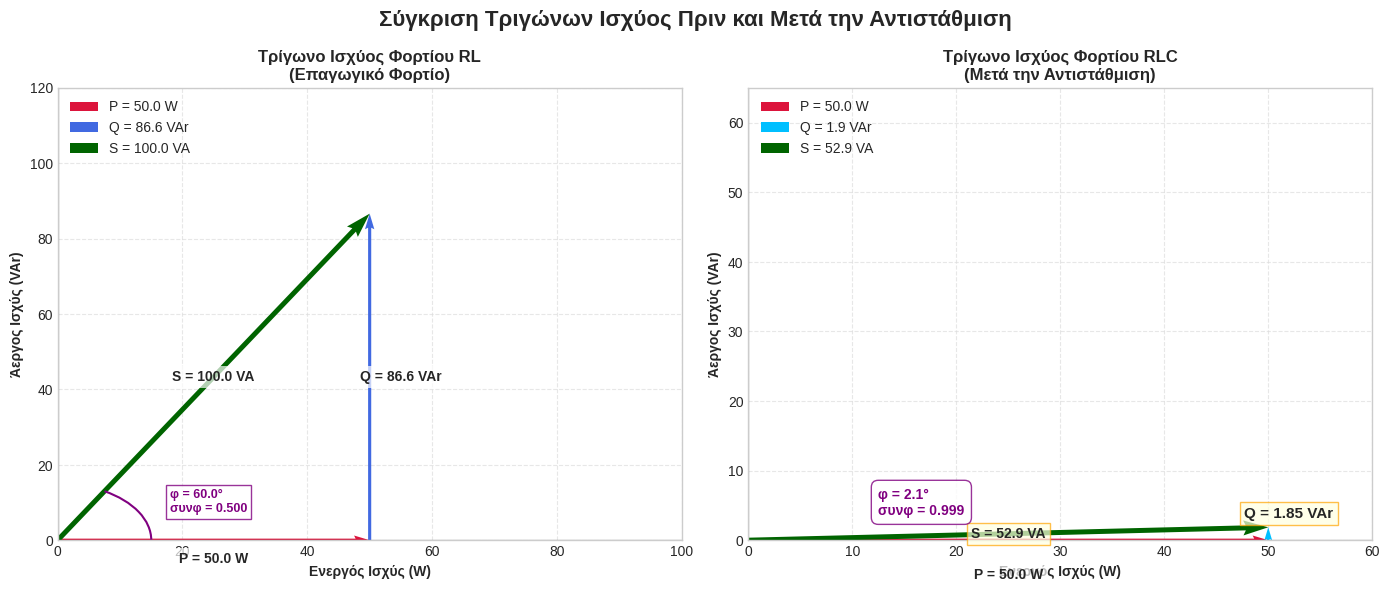

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

# Ορισμός συναρτήσεων βοηθητικών για την οπτικοποίηση
def draw_power_triangle(ax, P, Q, S, title, color_scheme=None, highlight_small_q=False):
    """
    Σχεδιάζει ένα τρίγωνο ισχύος με τις δοσμένες παραμέτρους

    Παράμετροι:
    - ax: Το αντικείμενο axes για το σχεδιασμό
    - P: Ενεργός ισχύς (W)
    - Q: Άεργος ισχύς (VAr)
    - S: Φαινόμενη ισχύς (VA)
    - title: Τίτλος του διαγράμματος
    - color_scheme: Προαιρετικό λεξικό με χρώματα για κάθε συνιστώσα
    - highlight_small_q: Αν είναι True, δίνει έμφαση σε μικρές τιμές Q
    """
    if color_scheme is None:
        color_scheme = {
            'P': 'crimson',       # Κόκκινο για την ενεργό ισχύ
            'Q': 'royalblue',     # Μπλε για την άεργο ισχύ
            'S': 'darkgreen',     # Πράσινο για τη φαινόμενη ισχύ
            'grid': '#DDDDDD',    # Ανοιχτό γκρι για το πλέγμα
            'angle': 'purple'     # Μωβ για τη γωνία φ
        }

    # Υπολογισμός της γωνίας φ (συντελεστής ισχύος)
    phi_rad = np.arctan2(Q, P)  # Χρήση arctan2 για σωστή διαχείριση τεταρτημορίων
    phi_deg = np.degrees(phi_rad)
    power_factor = np.cos(phi_rad)

    # Σχεδιασμός των διανυσμάτων ισχύος
    ax.quiver(0, 0, P, 0, angles='xy', scale_units='xy', scale=1,
              color=color_scheme['P'], width=0.005,
              label=f'P = {P:.1f} W')

    # Για μικρές τιμές Q, αυξάνουμε το πλάτος του διανύσματος για καλύτερη ορατότητα
    q_width = 0.010 if Q < 10 else 0.005
    ax.quiver(P, 0, 0, Q, angles='xy', scale_units='xy', scale=1,
              color=color_scheme['Q'], width=q_width,
              label=f'Q = {Q:.1f} VAr')

    ax.quiver(0, 0, P, Q, angles='xy', scale_units='xy', scale=1,
              color=color_scheme['S'], width=0.008,
              label=f'S = {S:.1f} VA')

    # Σχεδιασμός του τόξου για τη γωνία φ
    r = min(P, Q) * 0.3  # Ακτίνα του τόξου
    arc = Arc((0, 0), 2*r, 2*r, theta1=0, theta2=phi_deg,
              color=color_scheme['angle'], lw=1.5, linestyle='-')
    ax.add_patch(arc)

    # Προσθήκη σημειώσεων
    mid_P = P / 2
    mid_Q = Q / 2

    # Στυλ κειμένου
    text_style = {'fontsize': 10, 'fontweight': 'bold', 'ha': 'center', 'va': 'center',
                 'bbox': {'facecolor': 'white', 'alpha': 0.7, 'pad': 3, 'edgecolor': 'none'}}

    # Προσθήκη ετικετών για τις ισχύες
    ax.text(mid_P, -5, f'P = {P:.1f} W', **text_style)

    # Προσαρμογή για μικρές τιμές Q
    if Q < 10:
        # Ειδική τοποθέτηση για μικρές τιμές Q
        q_text_style = text_style.copy()
        q_text_style['bbox']['facecolor'] = 'lightyellow'
        q_text_style['bbox']['edgecolor'] = 'orange'
        q_text_style['fontsize'] = 11
        ax.text(P + 2, Q + 2, f'Q = {Q:.2f} VAr', **q_text_style)
    else:
        ax.text(P + 5, mid_Q, f'Q = {Q:.1f} VAr', **text_style)

    ax.text(mid_P, mid_Q, f'S = {S:.1f} VA', **text_style)

    # Προσθήκη ετικέτας για τη γωνία φ και τον συντελεστή ισχύος
    angle_label = f'φ = {phi_deg:.1f}°\nσυνφ = {power_factor:.3f}'

    # Για μικρές τιμές Q, προσαρμόζουμε τη θέση της ετικέτας
    if Q < 10:
        ax.text(P/4, Q*2, angle_label, color=color_scheme['angle'],
                fontsize=10, fontweight='bold',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3,
                      'edgecolor': color_scheme['angle'], 'boxstyle': 'round,pad=0.5'})
    else:
        ax.text(r*1.2, r*0.5, angle_label, color=color_scheme['angle'],
                fontsize=9, fontweight='bold',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3, 'edgecolor': color_scheme['angle']})

    # Ρύθμιση αξόνων και λεπτομερειών
    if Q < 10:  # Για μικρές τιμές Q (π.χ. το δεύτερο τρίγωνο)
        ax.set_xlim(0, P * 1.2)
        ax.set_ylim(0, max(Q * 3.7, P * 1.3))  # Προσαρμοσμένο zoom για το δεύτερο τρίγωνο
    else:
        ax.set_xlim(0, S * 1)
        ax.set_ylim(0, S * 1.2)
    ax.set_xlabel('Ενεργός Ισχύς (W)', fontweight='bold')
    ax.set_ylabel('Άεργος Ισχύς (VAr)', fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, color=color_scheme['grid'], linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.legend(loc='upper left', framealpha=0.9)

# --- Δεδομένα για το 1ο Τρίγωνο Ισχύος (φορτίο RL) ---
P1 = 50.0    # Ενεργός Ισχύς (W)
Q1 = 86.6    # Άεργος Ισχύς (VAr) - Επαγωγική
S1 = 100.0   # Φαινόμενη Ισχύς (VA)

# --- Δεδομένα για το 2ο Τρίγωνο Ισχύος (φορτίο RLC μετά την αντιστάθμιση) ---
P2 = 50.0    # Ενεργός Ισχύς (W)
Q2 = 1.85    # Άεργος Ισχύς (VAr) - Επαγωγική (μετά την αντιστάθμιση)
S2 = 52.9    # Φαινόμενη Ισχύς (VA)

# Έλεγχος συνέπειας δεδομένων
print(f"1ο Τρίγωνο - Έλεγχος: S = √(P² + Q²) = √({P1}² + {Q1}²) = {np.sqrt(P1**2 + Q1**2):.1f} VA")
print(f"2ο Τρίγωνο - Έλεγχος: S = √(P² + Q²) = √({P2}² + {Q2}²) = {np.sqrt(P2**2 + Q2**2):.1f} VA")

# --- Δημιουργία σχήματος με τα δύο τρίγωνα δίπλα-δίπλα ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Σύγκριση Τριγώνων Ισχύος Πριν και Μετά την Αντιστάθμιση',
             fontsize=16, fontweight='bold', y=0.98)


# Χρωματικό σχήμα
colors = {
    'P': 'crimson',
    'Q': 'royalblue',
    'S': 'darkgreen',
    'grid': '#DDDDDD',
    'angle': 'purple'
}

# Σχεδιασμός 1ου τριγώνου ισχύος (RL φορτίο)
draw_power_triangle(
    ax1, P1, Q1, S1,
    'Τρίγωνο Ισχύος Φορτίου RL\n(Επαγωγικό Φορτίο)',
    colors
)

# Σχεδιασμός 2ου τριγώνου ισχύος (RLC φορτίο μετά την αντιστάθμιση)
# Χρησιμοποιούμε ένα ελαφρώς διαφορετικό χρωματικό σχήμα για να τονίσουμε το μικρό Q
colors_highlighted = colors.copy()
colors_highlighted['Q'] = 'deepskyblue'  # Πιο έντονο μπλε για το Q στο δεύτερο διάγραμμα

draw_power_triangle(
    ax2, P2, Q2, S2,
    'Τρίγωνο Ισχύος Φορτίου RLC\n(Μετά την Αντιστάθμιση)',
    colors_highlighted,
    highlight_small_q=True
)



# Ρυθμίσεις για το σχήμα συνολικά
plt.tight_layout()
plt.subplots_adjust(top=0.85)



# Εμφάνιση των διαγραμμάτων
plt.show()

1ο Τρίγωνο - S_calc = 100.0 VA (Παρεχόμενο S1=100.0 VA)
2ο Τρίγωνο - S_calc = 50.0 VA (Παρεχόμενο S2=52.9 VA)


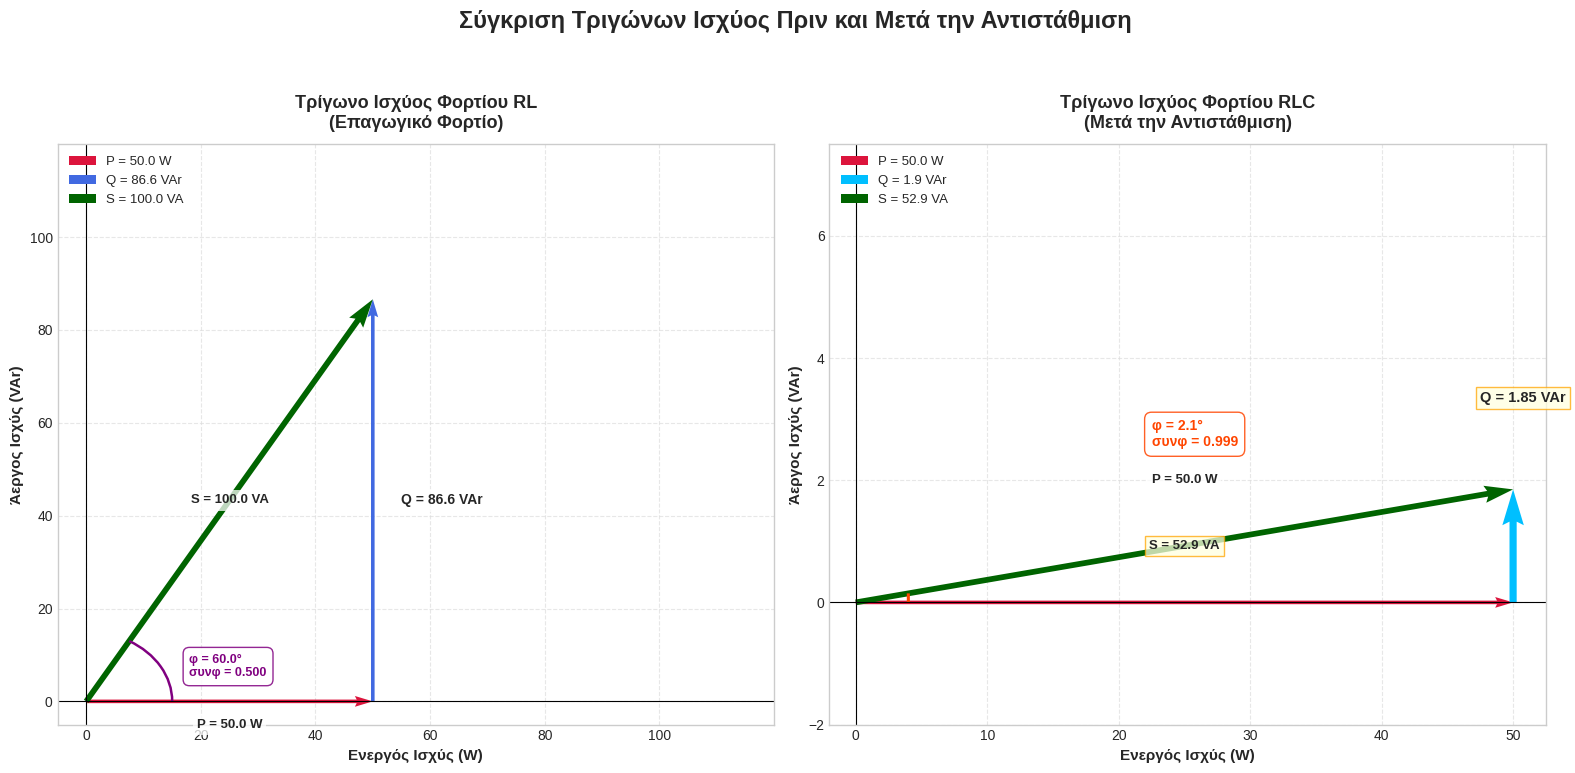

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

# Ορισμός συναρτήσεων βοηθητικών για την οπτικοποίηση
def draw_power_triangle(ax, P, Q, S, title, color_scheme=None):
    """
    Σχεδιάζει ένα τρίγωνο ισχύος με τις δοσμένες παραμέτρους.
    Προσαρμόζει το zoom για μικρές τιμές Q για καλύτερη ορατότητα.
    """
    if color_scheme is None:
        color_scheme = {
            'P': 'crimson',
            'Q': 'royalblue',
            'S': 'darkgreen',
            'grid': '#DDDDDD',
            'angle': 'purple'
        }

    phi_rad = np.arctan2(Q, P)
    phi_deg = np.degrees(phi_rad)
    power_factor = np.cos(phi_rad)

    # --- Καθορισμός παραμέτρων σχεδίασης βάσει του αν είναι μικρή η Q ---
    is_small_q_case = abs(Q) < 10 and P > 1e-6

    # Παράμετροι για όρια αξόνων, ακτίνα τόξου, και θέσεις επιγραφών
    if is_small_q_case:
        # Πολύ πιο επιθετικό zoom για την περίπτωση μικρής Q
        xlim_lower = -P * 0.04
        xlim_upper = P * 1.05  # Αρκετά σφιχτό γύρω από το P

        ylim_lower = -max(abs(Q) * 0.8, P * 0.04) # Μικρό αρνητικό περιθώριο
        ylim_upper = max(abs(Q) * 4.0, P * 0.15) # Δίνει στη Q σχετικά περισσότερο χώρο, ύψος για επιγραφές

        arc_radius_val = P * 0.08  # Μικρότερη ακτίνα τόξου για να ταιριάζει στο zoom
        arc_lw_val = 2.2
        arc_linestyle_val = '--'

        p_label_y_offset = P * 0.04 # Επιγραφή P ελαφρώς πάνω από τον άξονα x

        angle_label_x = P * 0.45
        angle_label_y = P * 0.06 # Για τοποθέτηση "μέσα στο τρίγωνο, κάτω δεξιά"
        angle_ha = 'left'
        angle_va = 'top'
        angle_fontsize = 10
        angle_bbox_pad = 4

        q_label_x_offset = P * 0.95 # Κοντά στην άκρη του P
        q_label_y_offset = Q + P*0.01 + (1 if Q >0 else -1) # Λίγο πάνω/κάτω από το Q
        q_label_fontsize = 10.5

    else: # Κανονική περίπτωση (π.χ. πρώτο διάγραμμα)
        current_S_val = np.sqrt(P**2 + Q**2)
        if current_S_val < 1e-6 : current_S_val = max(abs(P),abs(Q),1.0)
        xlim_lower = -current_S_val * 0.05
        xlim_upper = current_S_val * 1.2
        ylim_lower = -current_S_val * 0.05
        ylim_upper = current_S_val * 1.2

        if P > 1e-6 and abs(Q) > 1e-6:
            arc_radius_val = min(P, abs(Q)) * 0.3
        elif P > 1e-6:
            arc_radius_val = P * 0.2
        elif abs(Q) > 1e-6:
            arc_radius_val = abs(Q) * 0.2
        else:
            arc_radius_val = 0.1

        if arc_radius_val < 1e-5 and (P > 1e-6 or abs(Q) > 1e-6): # Fallback
             if P > 1e-6: arc_radius_val = P * 0.15
             elif abs(Q) > 1e-6: arc_radius_val = abs(Q) * 0.15

        arc_lw_val = 1.8
        arc_linestyle_val = '-'

        p_label_y_offset = -max(5, current_S_val*0.02)

        # Θέση για την ετικέτα της γωνίας στην κανονική περίπτωση
        angle_label_x_base = arc_radius_val if arc_radius_val > 1e-2 else P*0.1
        angle_label_y_base = arc_radius_val if arc_radius_val > 1e-2 else abs(Q)*0.1
        if P <= 1e-6 and abs(Q) <= 1e-6 : angle_label_x_base = 0.1; angle_label_y_base=0.1;
        angle_label_x = angle_label_x_base * 1.2
        angle_label_y = angle_label_y_base * 0.5
        angle_ha = 'left'
        angle_va = 'center'
        angle_fontsize = 9
        angle_bbox_pad = 3

        q_label_x_offset = P + max(5, P*0.02)
        q_label_y_offset = Q / 2
        q_label_fontsize = 10


    # --- Σχεδίαση Στοιχείων ---
    ax.set_xlim(xlim_lower, xlim_upper)
    ax.set_ylim(ylim_lower, ylim_upper)

    ax.quiver(0, 0, P, 0, angles='xy', scale_units='xy', scale=1,
              color=color_scheme['P'], width=0.005,
              label=f'P = {P:.1f} W')

    q_width = 0.010 if is_small_q_case else 0.005
    ax.quiver(P, 0, 0, Q, angles='xy', scale_units='xy', scale=1,
              color=color_scheme['Q'], width=q_width,
              label=f'Q = {Q:.1f} VAr')

    ax.quiver(0, 0, P, Q, angles='xy', scale_units='xy', scale=1,
              color=color_scheme['S'], width=0.008,
              label=f'S = {S:.1f} VA')

    if arc_radius_val > 1e-5 :
        arc = Arc((0, 0), 2 * arc_radius_val, 2 * arc_radius_val, theta1=0, theta2=phi_deg,
                  color=color_scheme['angle'], lw=arc_lw_val, linestyle=arc_linestyle_val)
        ax.add_patch(arc)

    mid_P = P / 2

    text_style_base = {'fontweight': 'bold', 'ha': 'center', 'va': 'center',
                       'bbox': {'facecolor': 'white', 'alpha': 0.75, 'pad': 3, 'edgecolor': 'none'}}

    # Επιγραφή P
    p_style = text_style_base.copy()
    p_style['fontsize'] = 9.5
    ax.text(mid_P, p_label_y_offset, f'P = {P:.1f} W', **p_style)

    # Επιγραφή Q
    q_style = text_style_base.copy()
    q_style['fontsize'] = q_label_fontsize
    if is_small_q_case:
        q_style['bbox']['facecolor'] = 'lightyellow'
        q_style['bbox']['edgecolor'] = 'orange'
        q_style['ha'] = 'left'
        ax.text(q_label_x_offset, q_label_y_offset, f'Q = {Q:.2f} VAr', **q_style)
    else:
        q_style['ha'] = 'left' # Προσαρμογή για γενική περίπτωση
        ax.text(q_label_x_offset, q_label_y_offset, f'Q = {Q:.1f} VAr', **q_style)

    # Επιγραφή S
    s_style = text_style_base.copy()
    s_style['fontsize'] = 9.5
    s_y_pos = Q/2
    if is_small_q_case : s_y_pos = max(Q/2, ylim_upper * 0.1) # Προσαρμογή S για να μη χαθεί στο zoom
    ax.text(mid_P, s_y_pos , f'S = {S:.1f} VA', **s_style)

    # Επιγραφή γωνίας φ και συντελεστή ισχύος
    angle_label_text = f'φ = {phi_deg:.1f}°\nσυνφ = {power_factor:.3f}'
    angle_bbox_style = {'facecolor': 'white', 'alpha': 0.85, 'pad': angle_bbox_pad,
                        'edgecolor': color_scheme['angle'], 'boxstyle': 'round,pad=0.5'}
    ax.text(angle_label_x, angle_label_y, angle_label_text, color=color_scheme['angle'],
            fontsize=angle_fontsize, fontweight='bold', ha=angle_ha, va=angle_va,
            bbox=angle_bbox_style)

    ax.set_xlabel('Ενεργός Ισχύς (W)', fontweight='bold', fontsize=11)
    ax.set_ylabel('Άεργος Ισχύς (VAr)', fontweight='bold', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold', pad=12)
    ax.grid(True, color=color_scheme['grid'], linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.legend(loc='upper left', framealpha=0.9, fontsize=9.5)


# --- Δεδομένα για το 1ο Τρίγωνο Ισχύος (φορτίο RL) ---
P1 = 50.0
Q1 = 86.6
S1 = 100.0

# --- Δεδομένα για το 2ο Τρίγωνο Ισχύος (φορτίο RLC μετά την αντιστάθμιση) ---
P2 = 50.0
Q2 = 1.85
S2 = 52.9 # Η τιμή S που δίνεται από τον χρήστη, η οποία διαφέρει από την υπολογιζόμενη sqrt(P2^2+Q2^2)

print(f"1ο Τρίγωνο - S_calc = {np.sqrt(P1**2 + Q1**2):.1f} VA (Παρεχόμενο S1={S1} VA)")
print(f"2ο Τρίγωνο - S_calc = {np.sqrt(P2**2 + Q2**2):.1f} VA (Παρεχόμενο S2={S2} VA)")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8)) # Αυξημένο μέγεθος για καλύτερη απεικόνιση
fig.suptitle('Σύγκριση Τριγώνων Ισχύος Πριν και Μετά την Αντιστάθμιση',
             fontsize=17, fontweight='bold')

colors = {
    'P': 'crimson', 'Q': 'royalblue', 'S': 'darkgreen',
    'grid': '#DDDDDD', 'angle': 'purple'
}
draw_power_triangle(ax1, P1, Q1, S1, 'Τρίγωνο Ισχύος Φορτίου RL\n(Επαγωγικό Φορτίο)', colors)

colors_highlighted = colors.copy()
colors_highlighted['Q'] = 'deepskyblue'
colors_highlighted['angle'] = 'orangered'
draw_power_triangle(ax2, P2, Q2, S2, 'Τρίγωνο Ισχύος Φορτίου RLC\n(Μετά την Αντιστάθμιση)', colors_highlighted)

plt.tight_layout(rect=[0, 0.02, 1, 0.94]) # Προσαρμογή για τον βασικό τίτλο και τους άξονες
plt.show()

1ο Τρίγωνο - S_calc = 100.0 VA (Παρεχόμενο S1=100.0 VA)
2ο Τρίγωνο - S_calc = 50.0 VA (Παρεχόμενο S2=52.9 VA)


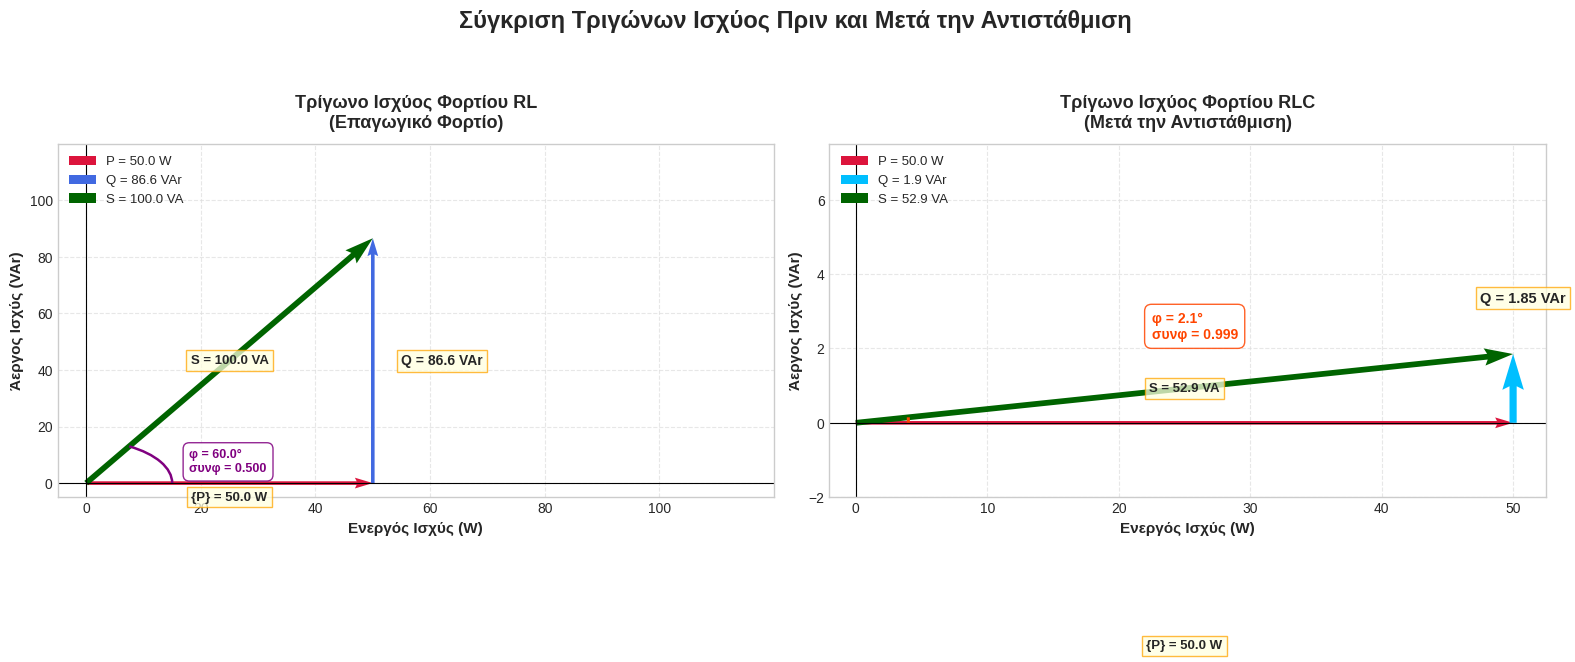

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

# Ορισμός συναρτήσεων βοηθητικών για την οπτικοποίηση
def draw_power_triangle(ax, P, Q, S, title, color_scheme=None):
    """
    Σχεδιάζει ένα τρίγωνο ισχύος με τις δοσμένες παραμέτρους.
    Προσαρμόζει το zoom για μικρές τιμές Q για καλύτερη ορατότητα.
    """
    if color_scheme is None:
        color_scheme = {
            'P': 'crimson',
            'Q': 'royalblue',
            'S': 'darkgreen',
            'grid': '#DDDDDD',
            'angle': 'purple'
        }

    phi_rad = np.arctan2(Q, P)
    phi_deg = np.degrees(phi_rad)
    power_factor = np.cos(phi_rad)

    # --- Καθορισμός παραμέτρων σχεδίασης βάσει του αν είναι μικρή η Q ---
    is_small_q_case = abs(Q) < 10 and P > 1e-6

    # Παράμετροι για όρια αξόνων, ακτίνα τόξου, και θέσεις επιγραφών
    if is_small_q_case:
        # Πολύ πιο επιθετικό zoom για την περίπτωση μικρής Q
        xlim_lower = -P * 0.04
        xlim_upper = P * 1.05  # Αρκετά σφιχτό γύρω από το P

        ylim_lower = -max(abs(Q) * 0.8, P * 0.04) # Μικρό αρνητικό περιθώριο
        ylim_upper = max(abs(Q) * 4.0, P * 0.15) # Δίνει στη Q σχετικά περισσότερο χώρο, ύψος για επιγραφές

        arc_radius_val = P * 0.08  # Μικρότερη ακτίνα τόξου για να ταιριάζει στο zoom
        arc_lw_val = 2.2
        arc_linestyle_val = '--'

        p_label_y_offset = -P * 0.12 # Επιγραφή P πιο κάτω

        angle_label_x = P * 0.45
        angle_label_y = P * 0.06 # Για τοποθέτηση "μέσα στο τρίγωνο, κάτω δεξιά"
        angle_ha = 'left'
        angle_va = 'top'
        angle_fontsize = 10
        angle_bbox_pad = 4

        q_label_x_offset = P * 0.95 # Κοντά στην άκρη του P
        q_label_y_offset = Q + P*0.01 + (1 if Q >0 else -1) # Λίγο πάνω/κάτω από το Q
        q_label_fontsize = 10.5

    else: # Κανονική περίπτωση (π.χ. πρώτο διάγραμμα)
        current_S_val = np.sqrt(P**2 + Q**2)
        if current_S_val < 1e-6 : current_S_val = max(abs(P),abs(Q),1.0)
        xlim_lower = -current_S_val * 0.05
        xlim_upper = current_S_val * 1.2
        ylim_lower = -current_S_val * 0.05
        ylim_upper = current_S_val * 1.2

        if P > 1e-6 and abs(Q) > 1e-6:
            arc_radius_val = min(P, abs(Q)) * 0.3
        elif P > 1e-6:
            arc_radius_val = P * 0.2
        elif abs(Q) > 1e-6:
            arc_radius_val = abs(Q) * 0.2
        else:
            arc_radius_val = 0.1

        if arc_radius_val < 1e-5 and (P > 1e-6 or abs(Q) > 1e-6): # Fallback
            if P > 1e-6: arc_radius_val = P * 0.15
            elif abs(Q) > 1e-6: arc_radius_val = abs(Q) * 0.15

        arc_lw_val = 1.8
        arc_linestyle_val = '-'

        p_label_y_offset = -max(5, current_S_val*0.02)

        # Θέση για την ετικέτα της γωνίας στην κανονική περίπτωση
        angle_label_x_base = arc_radius_val if arc_radius_val > 1e-2 else P*0.1
        angle_label_y_base = arc_radius_val if arc_radius_val > 1e-2 else abs(Q)*0.1
        if P <= 1e-6 and abs(Q) <= 1e-6 : angle_label_x_base = 0.1; angle_label_y_base=0.1;
        angle_label_x = angle_label_x_base * 1.2
        angle_label_y = angle_label_y_base * 0.5
        angle_ha = 'left'
        angle_va = 'center'
        angle_fontsize = 9
        angle_bbox_pad = 3

        q_label_x_offset = P + max(5, P*0.02)
        q_label_y_offset = Q / 2
        q_label_fontsize = 10


    # --- Σχεδίαση Στοιχείων ---
    ax.set_xlim(xlim_lower, xlim_upper)
    ax.set_ylim(ylim_lower, ylim_upper)

    ax.quiver(0, 0, P, 0, angles='xy', scale_units='xy', scale=1,
                color=color_scheme['P'], width=0.005,
                label=f'P = {P:.1f} W')

    q_width = 0.010 if is_small_q_case else 0.005
    ax.quiver(P, 0, 0, Q, angles='xy', scale_units='xy', scale=1,
                color=color_scheme['Q'], width=q_width,
                label=f'Q = {Q:.1f} VAr')

    ax.quiver(0, 0, P, Q, angles='xy', scale_units='xy', scale=1,
                color=color_scheme['S'], width=0.008,
                label=f'S = {S:.1f} VA')

    if arc_radius_val > 1e-5 :
        arc = Arc((0, 0), 2 * arc_radius_val, 2 * arc_radius_val, theta1=0, theta2=phi_deg,
                  color=color_scheme['angle'], lw=arc_lw_val, linestyle=arc_linestyle_val)
        ax.add_patch(arc)

    mid_P = P / 2

    text_style_base = {'fontweight': 'bold', 'ha': 'center', 'va': 'center',
                        'bbox': {'facecolor': 'white', 'alpha': 0.75, 'pad': 3, 'edgecolor': 'none'}}

    # Επιγραφή P
    p_style = text_style_base.copy()
    p_style['fontsize'] = 9.5
    p_style['bbox']['facecolor'] = 'lightyellow'
    p_style['bbox']['edgecolor'] = 'orange'
    ax.text(mid_P, p_label_y_offset, f'{{P}} = {P:.1f} W', **p_style)

    # Επιγραφή Q
    q_style = text_style_base.copy()
    q_style['fontsize'] = q_label_fontsize
    if is_small_q_case:
        q_style['bbox']['facecolor'] = 'lightyellow'
        q_style['bbox']['edgecolor'] = 'orange'
        q_style['ha'] = 'left'
        ax.text(q_label_x_offset, q_label_y_offset, f'Q = {Q:.2f} VAr', **q_style)
    else:
        q_style['ha'] = 'left' # Προσαρμογή για γενική περίπτωση
        ax.text(q_label_x_offset, q_label_y_offset, f'Q = {Q:.1f} VAr', **q_style)

    # Επιγραφή S
    s_style = text_style_base.copy()
    s_style['fontsize'] = 9.5
    s_y_pos = Q/2
    if is_small_q_case : s_y_pos = max(Q/2, ylim_upper * 0.1) # Προσαρμογή S για να μη χαθεί στο zoom
    ax.text(mid_P, s_y_pos , f'S = {S:.1f} VA', **s_style)

    # Επιγραφή γωνίας φ και συντελεστή ισχύος
    angle_label_text = f'φ = {phi_deg:.1f}°\nσυνφ = {power_factor:.3f}'
    angle_bbox_style = {'facecolor': 'white', 'alpha': 0.85, 'pad': angle_bbox_pad,
                        'edgecolor': color_scheme['angle'], 'boxstyle': 'round,pad=0.5'}
    ax.text(angle_label_x, angle_label_y, angle_label_text, color=color_scheme['angle'],
            fontsize=angle_fontsize, fontweight='bold', ha=angle_ha, va=angle_va,
            bbox=angle_bbox_style)

    ax.set_xlabel('Ενεργός Ισχύς (W)', fontweight='bold', fontsize=11)
    ax.set_ylabel('Άεργος Ισχύς (VAr)', fontweight='bold', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold', pad=12)
    ax.grid(True, color=color_scheme['grid'], linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.legend(loc='upper left', framealpha=0.9, fontsize=9.5)


# --- Δεδομένα για το 1ο Τρίγωνο Ισχύος (φορτίο RL) ---
P1 = 50.0
Q1 = 86.6
S1 = 100.0

# --- Δεδομένα για το 2ο Τρίγωνο Ισχύος (φορτίο RLC μετά την αντιστάθμιση) ---
P2 = 50.0
Q2 = 1.85
S2 = 52.9 # Η τιμή S που δίνεται από τον χρήστη, η οποία διαφέρει από την υπολογιζόμενη sqrt(P2^2+Q2^2)

print(f"1ο Τρίγωνο - S_calc = {np.sqrt(P1**2 + Q1**2):.1f} VA (Παρεχόμενο S1={S1} VA)")
print(f"2ο Τρίγωνο - S_calc = {np.sqrt(P2**2 + Q2**2):.1f} VA (Παρεχόμενο S2={S2} VA)")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8)) # Αυξημένο μέγεθος για καλύτερη απεικόνιση
fig.suptitle('Σύγκριση Τριγώνων Ισχύος Πριν και Μετά την Αντιστάθμιση',
             fontsize=17, fontweight='bold')

colors = {
    'P': 'crimson', 'Q': 'royalblue', 'S': 'darkgreen',
    'grid': '#DDDDDD', 'angle': 'purple'
}
draw_power_triangle(ax1, P1, Q1, S1, 'Τρίγωνο Ισχύος Φορτίου RL\n(Επαγωγικό Φορτίο)', colors)

colors_highlighted = colors.copy()
colors_highlighted['Q'] = 'deepskyblue'
colors_highlighted['angle'] = 'orangered'
draw_power_triangle(ax2, P2, Q2, S2, 'Τρίγωνο Ισχύος Φορτίου RLC\n(Μετά την Αντιστάθμιση)', colors_highlighted)



plt.tight_layout(rect=[0, 0.02, 1, 0.94]) # Προσαρμογή για τον βασικό τίτλο και τους άξονες
plt.show()

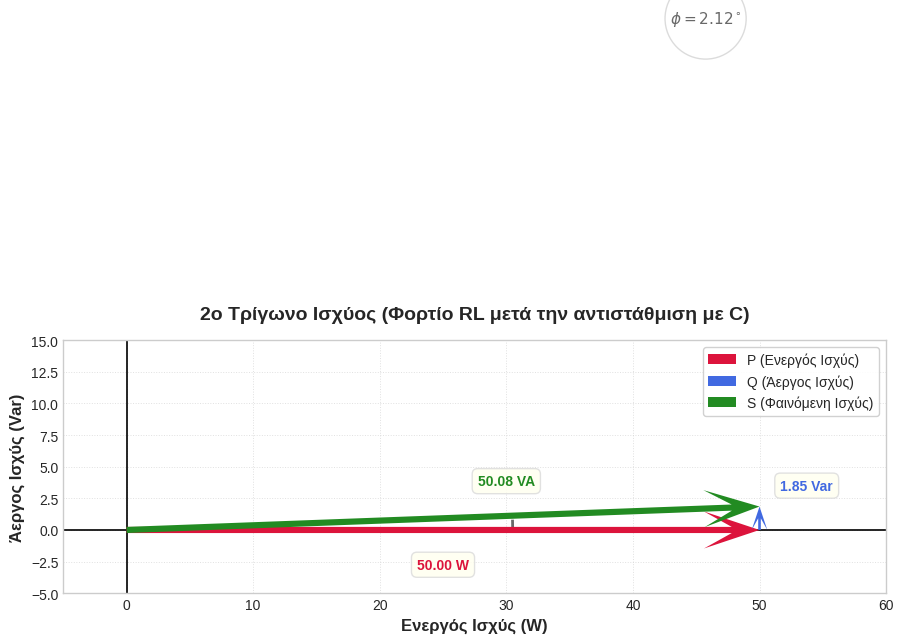

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

# --- Define plot style ---
plt.style.use('seaborn-v0_8-whitegrid')

# --- Define a common bounding box style for annotations ---
bbox_props = dict(boxstyle="round,pad=0.4", fc="ivory", ec="gainsboro", alpha=0.85)

def plot_power_triangle(ax, P, Q, S_val_label, title, common_max_lim):
    """
    Plots a power triangle on the given axes.
    """
    # Calculate angle phi using arctan2 for robustness
    phi_rad = np.arctan2(Q, P)
    phi_deg = np.degrees(phi_rad)

    # Arrow properties for better visibility
    arrow_head_width = 6
    arrow_head_length = 9
    arrow_line_width = 2.0  # Increased for better visibility

    # Colors
    color_P = 'crimson'
    color_Q = 'royalblue'
    color_S = 'forestgreen'
    color_phi = 'dimgray'

    # Plot P (Active Power) from origin along x-axis
    ax.quiver(0, 0, P, 0, angles='xy', scale_units='xy', scale=1, color=color_P,
              label='P (Ενεργός Ισχύς)', headwidth=arrow_head_width,
              headlength=arrow_head_length, linewidth=arrow_line_width, zorder=3)

    # Plot Q (Reactive Power) starting from the end of P, vertically
    ax.quiver(P, 0, 0, Q, angles='xy', scale_units='xy', scale=1, color=color_Q,
              label='Q (Άεργος Ισχύς)', headwidth=arrow_head_width,
              headlength=arrow_head_length, linewidth=arrow_line_width, zorder=3)

    # Plot S (Apparent Power) as the hypotenuse from origin to (P,Q)
    ax.quiver(0, 0, P, Q, angles='xy', scale_units='xy', scale=1, color=color_S,
              label='S (Φαινόμενη Ισχύς)', headwidth=arrow_head_width,
              headlength=arrow_head_length, linewidth=arrow_line_width, zorder=3)

    # --- Annotations with improved positions ---
    # P annotation (below the P arrow)
    ax.annotate(f'{P:.2f} W', xy=(P / 2, 0), textcoords="offset points", xytext=(0, -20),
                ha='center', va='top', color=color_P, bbox=bbox_props, fontsize=10, weight='bold')

    # Q annotation (to the right of the Q arrow)
    # For very small Q values, position the annotation better
    if abs(Q) < 5:
        ax.annotate(f'{Q:.2f} Var', xy=(P, Q), textcoords="offset points", xytext=(15, 10),
                    ha='left', va='bottom', color=color_Q, bbox=bbox_props, fontsize=10, weight='bold')
    else:
        ax.annotate(f'{Q:.2f} Var', xy=(P, Q / 2), textcoords="offset points", xytext=(20, 0),
                    ha='left', va='center', color=color_Q, bbox=bbox_props, fontsize=10, weight='bold')

    # S annotation (near the S arrow)
    # For small Q values, adjust the position to avoid overlapping with axes
    s_annot_x = P * 0.6
    s_annot_y = Q * 0.6
    if abs(Q) < 5:  # For very small reactive power
        s_offset_x = 0
        s_offset_y = 20  # Place it above the arrow
    else:
        s_offset_x = 10 * np.cos(phi_rad + np.pi/2)
        s_offset_y = 10 * np.sin(phi_rad + np.pi/2) + (5 if Q>0 else -5)

    ax.annotate(f'{S_val_label:.2f} VA', xy=(s_annot_x, s_annot_y),
                textcoords="offset points", xytext=(s_offset_x, s_offset_y),
                ha='center', va='bottom' if Q >=0 else 'top', color=color_S,
                bbox=bbox_props, fontsize=10, weight='bold')

    # --- Angle phi visualization ---
    # Draw an arc for phi if P or Q is non-zero
    if P**2 + Q**2 > 1e-6:
        # For small angles, make the arc more visible
        arc_display_radius = common_max_lim * 0.25  # Increased radius for better visibility

        phi_arc = Arc((0,0), width=arc_display_radius*2, height=arc_display_radius*2, angle=0,
                      theta1=0, theta2=phi_deg, color=color_phi, linestyle='--',
                      linewidth=2.0, zorder=2, label='_nolegend_')  # Thicker line
        ax.add_patch(phi_arc)

        # Position phi label for better visibility with small angles
        label_angle_rad = phi_rad / 2
        label_r_factor = 1.5  # Increased factor to position text further from origin

        phi_label_x = arc_display_radius * label_r_factor * np.cos(label_angle_rad)
        phi_label_y = arc_display_radius * label_r_factor * np.sin(label_angle_rad)

        # For very small angles, place the label above the arc
        if abs(phi_deg) < 5:
            phi_label_y = arc_display_radius * 1.3
            ha_phi, va_phi = 'center', 'bottom'
        else:
            ha_phi, va_phi = 'center', 'center'
            # Fine-tune alignment for edge cases
            if abs(phi_rad) < np.deg2rad(10):
                va_phi = 'bottom' if phi_rad >= 0 else 'top'
                phi_label_y += np.sign(phi_rad if phi_rad!=0 else 1) * common_max_lim * 0.01
            elif abs(abs(phi_rad) - np.pi/2) < np.deg2rad(10):
                ha_phi = 'left' if phi_rad > 0 else 'right'
                phi_label_x += np.sign(np.cos(label_angle_rad) if np.cos(label_angle_rad)!=0 else 1) * common_max_lim * 0.01

        ax.text(phi_label_x, phi_label_y, f'$\phi = {phi_deg:.2f}^\circ$',
                ha=ha_phi, va=va_phi, color=color_phi, fontsize=11, weight='bold',
                bbox=dict(boxstyle="circle,pad=0.3", fc="white", alpha=0.8, ec="lightgray"))

    # --- Plot settings ---
    # Custom limits for the 2nd triangle to zoom in and show the small Q value better
    if abs(Q) < 5:  # For the compensated circuit with small Q
        y_max = 15  # Custom y-axis limit to zoom in
        ax.set_xlim(-5, P * 1.2)
        ax.set_ylim(-5, y_max)
    else:
        ax.set_xlim(-common_max_lim * 0.05, common_max_lim)
        ax.set_ylim(-common_max_lim * 0.05, common_max_lim)

    ax.set_xlabel('Ενεργός Ισχύς (W)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Άεργος Ισχύς (Var)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, weight='bold', pad=15)

    # Add legend, placed in a suitable location
    ax.legend(loc='upper right', fontsize=10, frameon=True, framealpha=0.9, fancybox=True)

    # Grid settings - make it less obtrusive
    ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.6)

    # Axis lines (origin lines) - make them more visible
    ax.axhline(0, color='black', linewidth=1.2, zorder=1)
    ax.axvline(0, color='black', linewidth=1.2, zorder=1)

    # Set aspect ratio to 'equal' so that the triangle is visually correct
    ax.set_aspect('equal', adjustable='box')

# --- Δεδομένα για το 2ο Τρίγωνο Ισχύος (RLC φορτίο μετά την αντιστάθμιση) ---
P2 = 50      # Ενεργός Ισχύς (W)
Q2 = 1.85    # Άεργος Ισχύς (Var) - Επαγωγική (πολύ μικρή μετά την αντιστάθμιση)
S2_label = 50.08  # Φαινόμενη Ισχύς (VA) - Recalculated as sqrt(P2^2 + Q2^2) for accuracy

# Common plot limit (from original code)
common_plot_limit = 100 * 1.22  # Based on first triangle's S value

# --- Δημιουργία και Εμφάνιση του 2ου Τριγώνου Ισχύος ---
plt.figure(figsize=(9, 8))  # Larger figure size for better visibility
ax2 = plt.subplot(111)
plot_power_triangle(ax2, P2, Q2, S2_label, '2ο Τρίγωνο Ισχύος (Φορτίο RL μετά την αντιστάθμιση με C)', common_plot_limit)
plt.tight_layout(pad=1.0)
plt.show()